In [1139]:
import matplotlib.pyplot as plt
import numpy as np
from util.functions import get_data_ticker, dias_uteis_entre_datas, decompor_sinal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
import util.functions as funcs
from sklearn.model_selection import train_test_split
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, accuracy_score, precision_score



In [1140]:
EMPRESA = 'VALE3.SA'
#EMPRESA = 'ITUB4.SA'
#EMPRESA = 'ELET3.SA'
#EMPRESA = 'PETR4.SA'
SEED = 42
qtdTeste = 0.2
features = ['Close']
features_trend = ['Close','tomorrow']


In [1141]:
dados = get_data_ticker(EMPRESA, period='5y')
dados.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [1142]:
dates, X, y = funcs.split_df_X_y(dados)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=qtdTeste, shuffle=False)

In [1143]:
if 'Close' in features:
    close_index = features.index('Close')

    close_values= [X_train[i, :, close_index] for i in range(X_train.shape[0])]
    X_train_plot = [arr[0] for arr in close_values]

    close_values= [X_test[i, :, close_index] for i in range(X_test.shape[0])]
    X_test_plot = [arr[0] for arr in close_values]


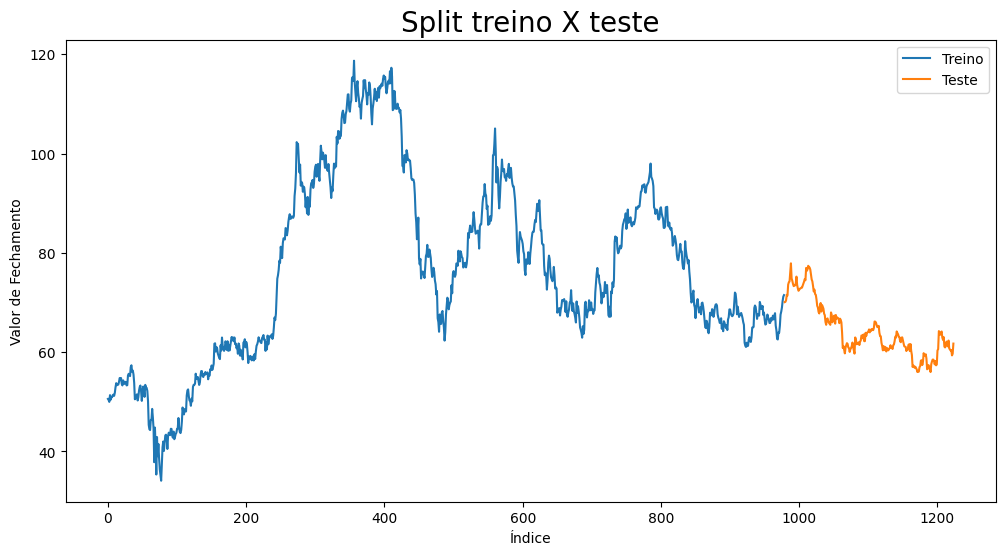

In [1144]:

dtr_plot = pd.DataFrame({'tomorrow':y_train})
dte_plot = pd.DataFrame({'tomorrow':y_test})
dtr_plot['tipo'] = 'treino'
dte_plot['tipo'] = 'teste'

# Adicionar índices sequenciais
dtr_plot['index'] = range(len(dtr_plot))
dte_plot['index'] = range(len(dtr_plot), len(dtr_plot) + len(dte_plot))

# Concatenar os DataFrames
dados_concat = pd.concat([dtr_plot, dte_plot])

plt.figure(figsize=(12, 6))
plt.plot(dtr_plot['index'], dtr_plot['tomorrow'], label='Treino')
plt.plot(dte_plot['index'], dte_plot['tomorrow'], label='Teste')
plt.title("Split treino X teste", fontsize=20)
plt.xlabel('Índice')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [1145]:
#GridSearchCV

# {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

# Definindo os parâmetros a serem testados
# param_grid = {
    # 'n_estimators': [100, 200, 300],
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
# }

# Criando o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                        #    param_grid=param_grid,
                        #    cv=5,
                        #    n_jobs=-1)

# Realizando a busca
# grid_search.fit(X_treino, y_treino)

# Obtendo os melhores parâmetros
# melhores_parametros = grid_search.best_params_
# melhores_parametros

In [1146]:
melhores_parametros = {
'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200,
 'max_features': 'log2'
}

modelo = RandomForestRegressor(**melhores_parametros)

In [1147]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Treina o modelo
modelo.fit(X_train_reshaped, y_train)

# Faz previsões no conjunto de teste
previsoes = modelo.predict(X_test_reshaped)

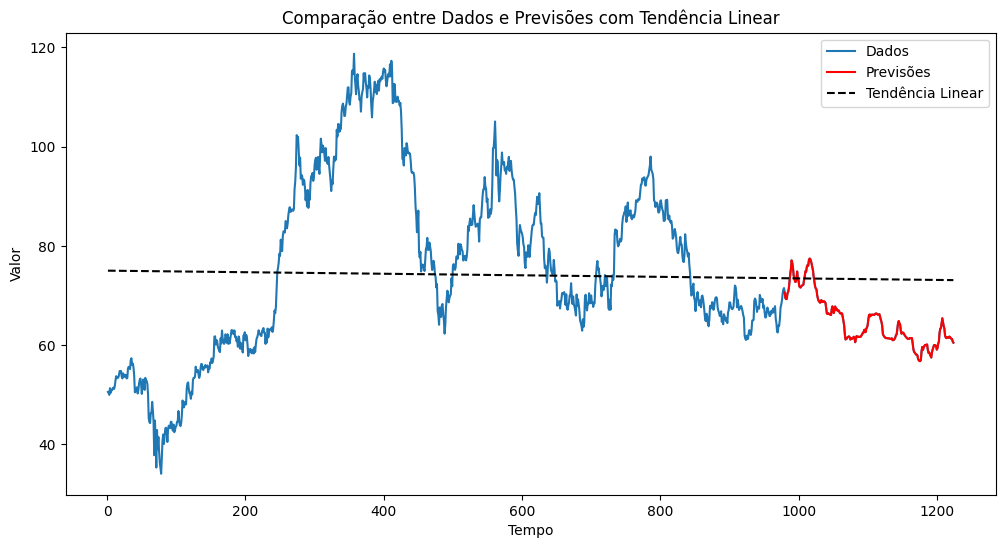

In [1148]:
import matplotlib.pyplot as plt

# ... (seu código anterior)

# Assumindo que X_train[:, -1] contém os últimos valores usados para a primeira previsão
primeira_previsao = len(y_train) + 1  # Índice da primeira previsão

# Criando um array com os valores reais e as previsões
dados_plot = np.concatenate([dados['Close'][primeira_previsao-len(X_train[:, -1]):primeira_previsao], previsoes])
tempo = np.arange(primeira_previsao-len(X_train[:, -1]), primeira_previsao+len(previsoes))

# Calculando a regressão linear
coefs = np.polyfit(tempo, dados_plot, 1)  # Ajusta uma reta (grau 1)

# Criando a linha de tendência
poly1d_fn = np.poly1d(coefs)

# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(tempo, dados_plot, label='Dados')
plt.plot(tempo[len(X_train[:, -1]):], previsoes, label='Previsões', color='red')
plt.plot(tempo, poly1d_fn(tempo), '--k', label='Tendência Linear')
plt.title("Comparação entre Dados e Previsões com Tendência Linear")
plt.legend()
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

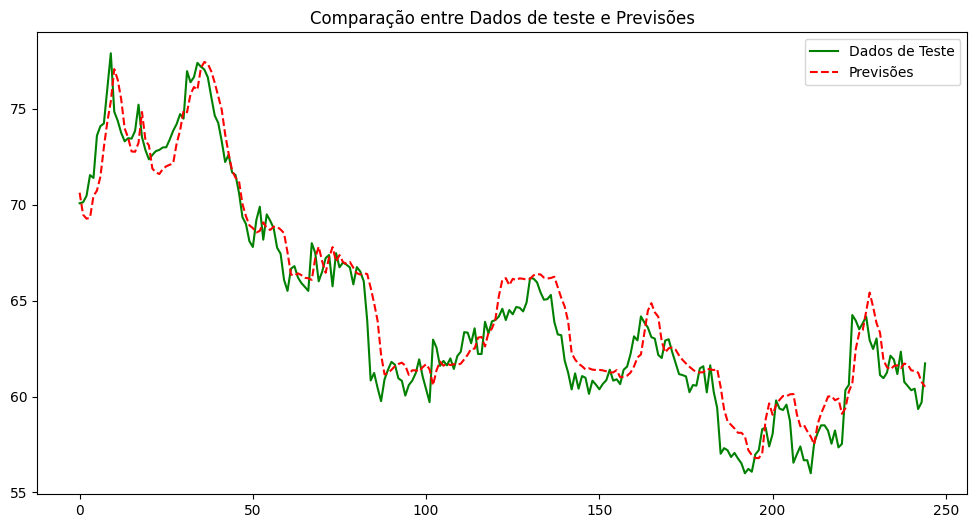

In [1149]:
# Visualização das previsões
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Dados de Teste', color='green')
plt.plot(previsoes, color='red', linestyle='--', label='Previsões')
plt.title("Comparação entre Dados de teste e Previsões")
plt.legend()
plt.show()

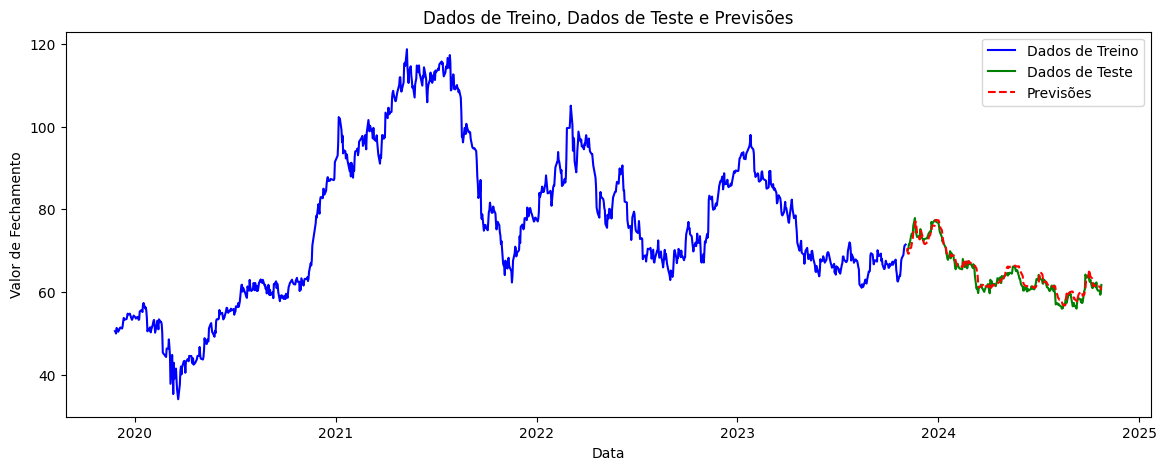

In [1150]:
index_train = dados.index[:len(dados) - len(y_test)]
index_test = dados.index[len(dados) - len(y_test):]

# Valores reais de treino e teste
train_values = dados['tomorrow'][:len(dados) - len(y_test)]
test_values = dados['tomorrow'][len(dados) - len(y_test):]

# Plotando o gráfico
plt.figure(figsize=(14, 5))

# Plotando os valores reais de treino
plt.plot(index_train, train_values, color='blue', label='Dados de Treino')

# Plotando os valores reais de teste
plt.plot(index_test, test_values, color='green', label='Dados de Teste')

# Plotando as previsões
plt.plot(index_test, previsoes, color='red', linestyle='--', label='Previsões')

plt.title('Dados de Treino, Dados de Teste e Previsões')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [1151]:
# Avaliação do modelo
mse = mean_squared_error(y_test, previsoes)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, previsoes)
r2 = r2_score(y_test, previsoes)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"r2: {r2}")

Mean Squared Error: 1.8221168954654652
Root Mean Squared Error: 1.349858101974228
Mean Absolute Error: 1.0818597552076838
r2: 0.9396882538913851


In [1152]:
X_test_reshaped

array([[71.5     , 71.2     , 70.32    , 69.      , 70.04    , 66.71571 ],
       [70.08    , 71.5     , 71.2     , 70.32    , 70.42    , 66.914764],
       [70.13    , 70.08    , 71.5     , 71.2     , 70.645996, 67.07047 ],
       ...,
       [60.41    , 60.33    , 60.55    , 60.76    , 60.878   , 62.002857],
       [59.35    , 60.41    , 60.33    , 60.55    , 60.28    , 61.955715],
       [59.7     , 59.35    , 60.41    , 60.33    , 60.068   , 61.91238 ]],
      dtype=float32)

In [1172]:
import numpy as np

def previsoes_iterativas(modelo, X_test_reshaped, num_previsoes, num_features):
    total_previsoes = np.zeros((num_previsoes, num_features))    
    # Armazena o último valor de X_test_reshaped como a primeira previsão
    total_previsoes[0] = test_values[-1]

    # Começa as previsões a partir da segunda posição
    for i in range(1, num_previsoes):
        
        # Faz a previsão com o modelo e garante o formato correto
        previsao = modelo.predict(X_test_reshaped)
        
        # Garante que previsao seja 1D com o número correto de features
        previsao = previsao.flatten()[:num_features]
        
        # Armazena a previsão no array de previsões
        total_previsoes[i] = previsao
        
        # Atualiza X_test_reshaped para incluir a previsão mais recente
        X_test_reshaped = np.roll(X_test_reshaped, -1)  # Remove o valor mais antigo
        X_test_reshaped[0, -num_features:] = previsao  # Adiciona a nova previsão no final

    return total_previsoes

# Exemplo de uso:
prever_dias = 45
total_previsoes = previsoes_iterativas(modelo, X_test_reshaped, prever_dias, num_features=1)
total_previsoes


array([[61.72999954],
       [70.63544336],
       [70.42280184],
       [69.25700687],
       [68.95227344],
       [69.16580892],
       [69.24983605],
       [69.23807066],
       [69.13714114],
       [68.8365173 ],
       [68.83056502],
       [68.83056502],
       [68.83056502],
       [68.83056502],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ],
       [68.8155998 ]])

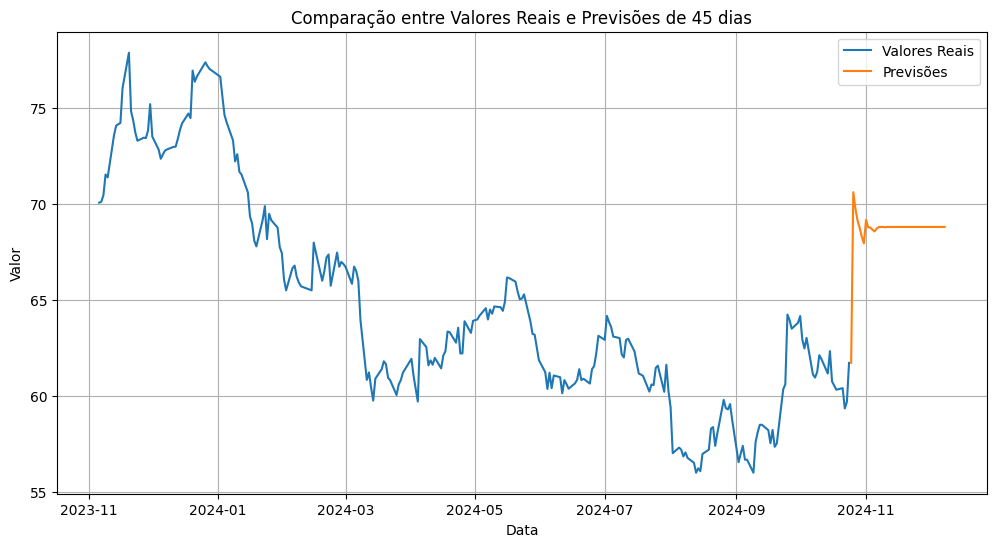

In [1154]:
# Criando um DataFrame para as previsões
last_date = test_values.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta('1 day'), periods=prever_dias)
df_previsoes = pd.DataFrame(total_previsoes, index=future_dates, columns=['previsoes'])

# Concatenando os DataFrames
df_completo = pd.concat([test_values, df_previsoes])

# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(df_completo[0], label='Valores Reais')
plt.plot(df_completo['previsoes'], label='Previsões')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Comparação entre Valores Reais e Previsões de 45 dias')
plt.legend()
plt.grid(True)
plt.show()